In [121]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import json

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, auc
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle

- train_collection: training csv files
- test collection: testing csv files

In [51]:
dir_train = r'../data/train/'
train_files = os.listdir(dir_train)
dir_train = [dir_train+file for file in train_files]
train_collection = {}
train_instances = [re.search('[a-z0-9_]*', file).group() for file in train_files]

dir_test = r'../data/test/'
test_files = os.listdir(dir_test)
dir_test = [dir_test+file for file in test_files]
test_collection = {}
test_instances = [re.search('[a-z0-9_]*', file).group() for file in test_files]

for df, dir in zip(train_instances, dir_train):
    try:
        if df == "bending2_dataset4":
            train_collection[df] = pd.read_csv(r'../data/train/bending2_dataset4.csv', skiprows=5, names=['time', 'avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'], delimiter=" ").iloc[:, :-1]
            train_collection[df].columns = ['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
            print(train_collection[df])
        else:
            train_collection[df] = pd.read_csv(dir, skiprows=5, names=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']).set_index('time')
        print(f'parsed {df}')
    except:
        print(f'error parsing {df} file')
        continue

for df, dir in zip(test_instances, dir_test):
    try:
        test_collection[df] = pd.read_csv(dir, skiprows=5, names=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']).set_index('time')
        print(f'parsed {df}')
    except:
        print(f'error parsing {df} file')
        continue

parsed sitting_dataset9
parsed sitting_dataset8
parsed cycling_dataset14
parsed standing_dataset15
parsed standing_dataset14
parsed cycling_dataset15
parsed cycling_dataset11
parsed standing_dataset10
parsed standing_dataset11
parsed cycling_dataset10
parsed standing_dataset9
parsed cycling_dataset12
parsed cycling_dataset8
parsed lying_dataset9
parsed standing_dataset13
parsed standing_dataset12
parsed lying_dataset8
parsed cycling_dataset9
parsed cycling_dataset13
parsed standing_dataset8
parsed bending2_dataset3
parsed walking_dataset8
parsed bending2_dataset6
parsed walking_dataset9
parsed bending2_dataset5
        avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0           32.50       0.50       0.00       0.00      19.00       1.00
250         32.50       0.50       0.00       0.00      18.50       0.50
500         32.75       0.43       1.00       0.00      18.00       0.00
750         32.50       0.50       0.00       0.00      17.50       0.50
1000        32.5

In [3]:
print(f'Training Dataset: {len(train_collection)} instances')
print(f'Testing Dataset: {len(test_collection)} instances')

Training Dataset: 69 instances
Testing Dataset: 19 instances


In [52]:
train_collection['bending2_dataset4'] # training data

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,32.50,0.50,0.00,0.00,19.00,1.00
250,32.50,0.50,0.00,0.00,18.50,0.50
500,32.75,0.43,1.00,0.00,18.00,0.00
750,32.50,0.50,0.00,0.00,17.50,0.50
1000,32.50,0.50,7.50,0.50,17.50,0.87
...,...,...,...,...,...,...
118750,28.67,0.47,4.67,1.25,17.33,0.47
119000,27.50,0.50,5.50,2.50,17.25,1.30
119250,28.00,0.00,6.67,0.94,17.00,1.00
119500,28.00,0.00,5.00,0.82,17.00,0.71


<h4>Selected Features</h4>
<li>Feature 1: 'max'</li>
<li>Feature 2: '3rdQuartile'</li>
<li>Feature 3: 'median'</li>

<hr>
<h2>2(a) Binary Classification using Logistic Regression</h2>

<h4>2ai.</h4>

In [28]:
# bending activity depicted as '1'
# non-bending activities depicted as '0'

In [53]:
# Function to find activities corresponding to bending to give a label.
def label_find_binary(x):
    try:
        return re.search('bending', x).group()
    except AttributeError:
        return False

In [54]:
# Make a list of all csv file names for reference (instances)
instances = [instance for instance in train_collection.keys()]


# Dictionary to store all instances and their statistical properties
train_stats = {}

for i in instances:
    for idx, col in enumerate(train_collection[i]):
        if col in ['avg_rss12', 'var_rss12', 'var_rss23']:
            train_stats['activity'] = instances
            train_stats[f'max{idx+1}'] = [train_collection[instance][col].max() for instance in train_collection.keys()]
            train_stats[f'3rdQuartile{idx+1}'] = [train_collection[instance][col].quantile(q=0.75) for instance in train_collection.keys()]
            train_stats[f'median{idx+1}'] = [train_collection[instance][col].median() for instance in train_collection.keys()]

df_2ai = pd.DataFrame(train_stats)
df_2ai['label'] = df_2ai['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)

df_2ai

,activity,max1,3rdQuartile1,median1,max2,3rdQuartile2,median2,max6,3rdQuartile6,median6,label
0,sitting_dataset9,46.50,44.50,42.50,1.50,0.50,0.43,5.45,1.0900,0.82,0
1,sitting_dataset8,45.00,43.50,42.50,1.12,0.50,0.43,6.36,1.0900,0.82,0
2,cycling_dataset14,43.50,39.25,36.75,9.71,3.74,2.17,11.15,4.6175,3.11,0
3,standing_dataset15,47.33,45.75,45.00,4.50,0.50,0.43,5.91,1.5000,0.94,0
4,standing_dataset14,45.75,45.00,44.75,2.83,0.50,0.00,3.83,0.8300,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...
64,standing_dataset7,48.00,48.00,46.00,4.50,0.50,0.00,6.00,1.1200,0.83,0
65,sitting_dataset6,38.67,37.00,30.25,2.49,1.00,0.00,5.12,1.0000,0.71,0
66,sitting_dataset7,50.75,42.00,36.75,6.06,0.50,0.43,5.17,1.0900,0.82,0
67,sitting_dataset5,45.75,42.50,36.50,12.19,0.82,0.00,6.26,1.1450,0.83,0


In [55]:
df_2ai['label'].value_counts()

0    60
1     9
Name: label, dtype: int64

- 60 non-bending activities
- 9 bending activities

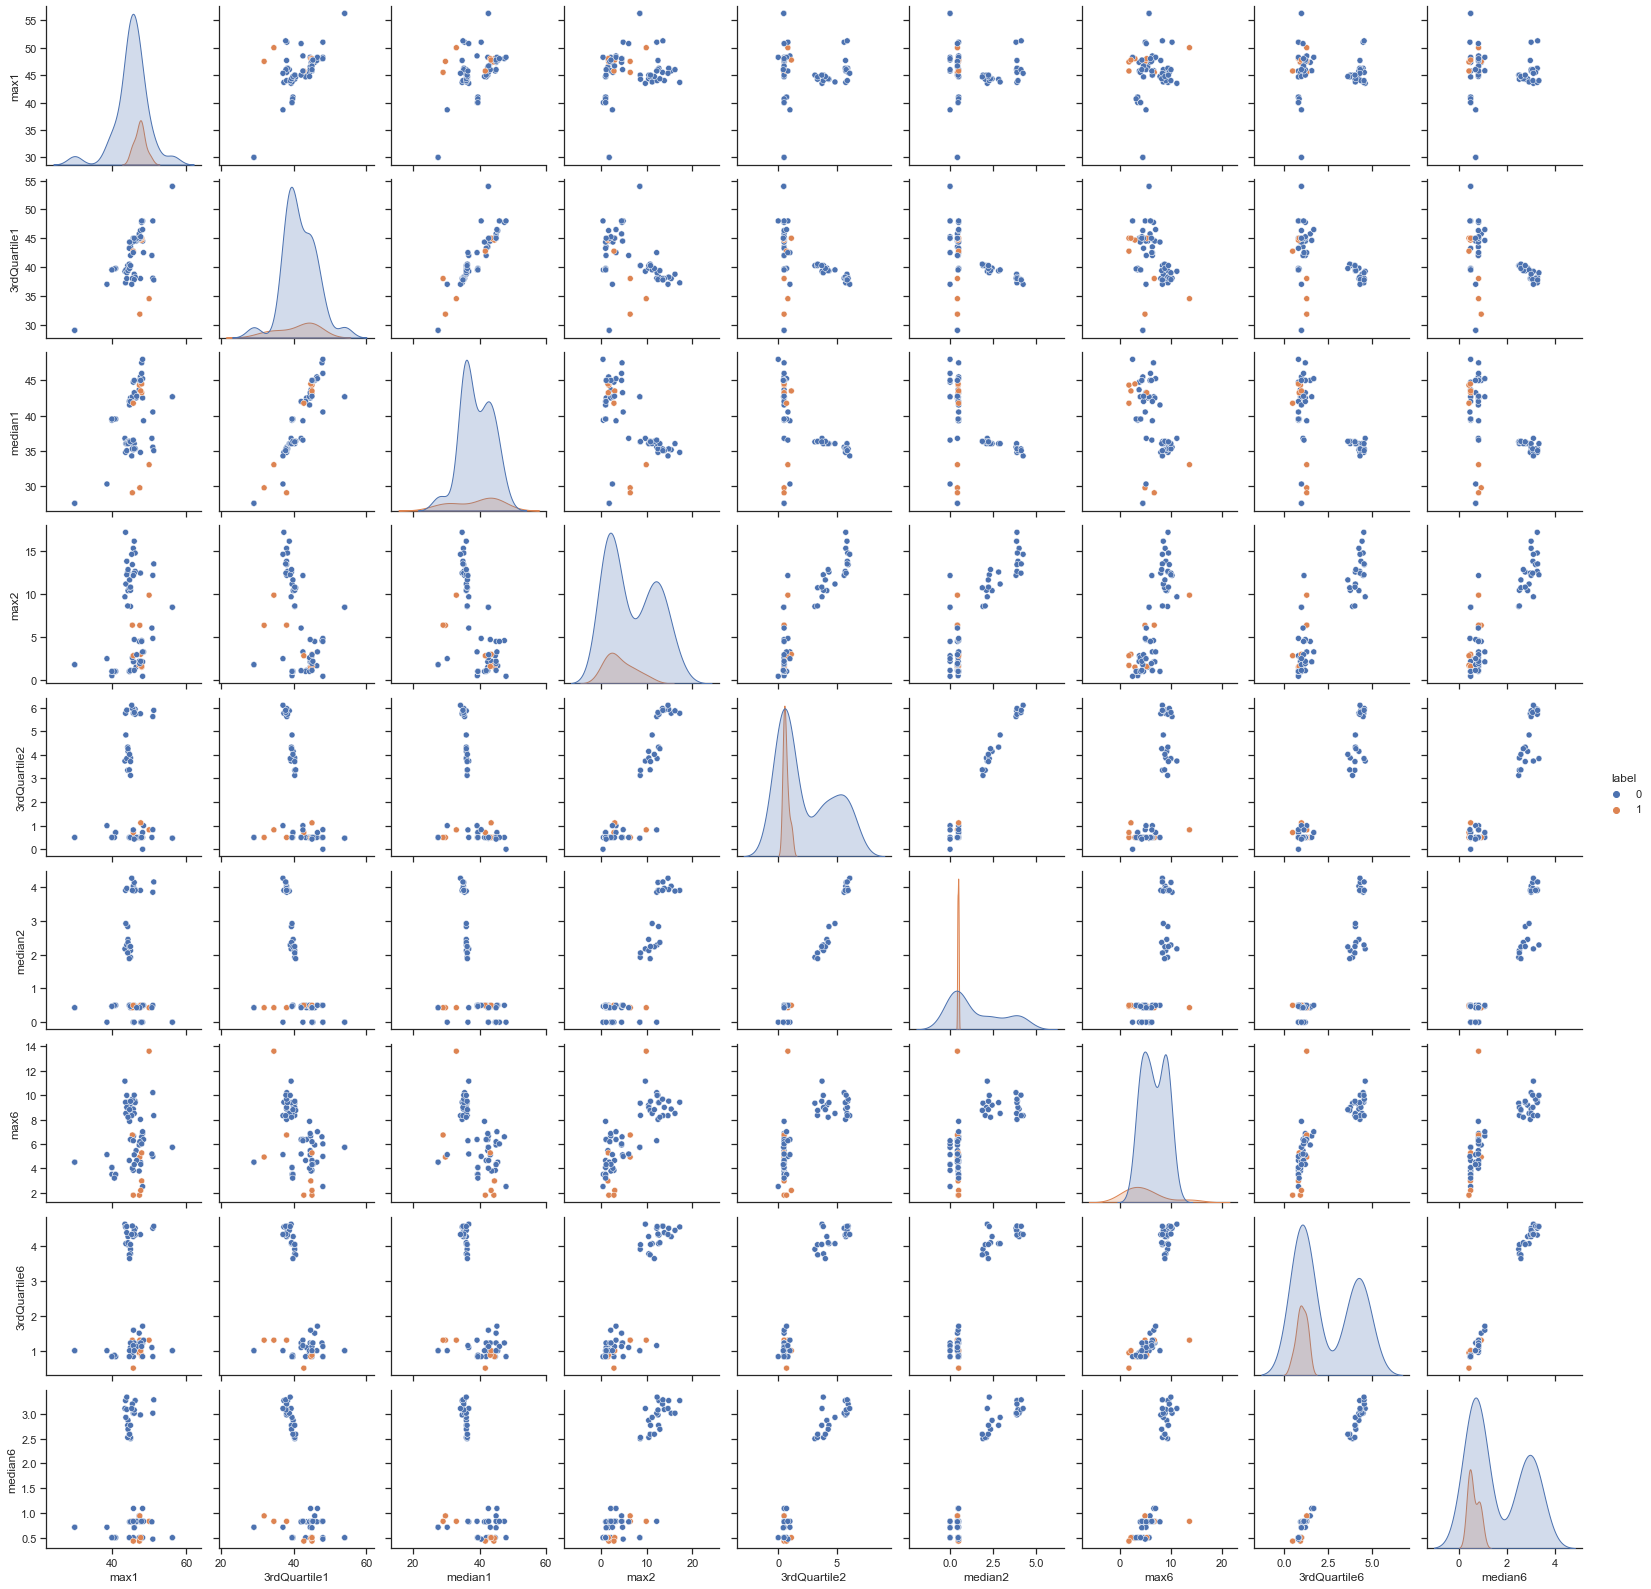

In [6]:
sns.set_theme(style="ticks")

sns.pairplot(df.iloc[:, 1:], hue="label")

<hr>
<h4>2aii.</h4>

- all_instances dict: A dictionary that contains the 2-equal length time series concatenated together for each training csv file.
- train_stats dict: A dictionary that contains all training csv files with statistical properties
- df_aii: dataframe that contains train_stats dict

In [10]:
all_instances = {}

for instance in train_collection.keys():
    # For every dataset in train collection dict, it makes 2 separate datasets
    group = np.array_split(train_collection[instance], 2)

    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
train_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        train_stats['activity'] = instances
        train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_2aii = pd.DataFrame(train_stats)
df_2aii['label'] = df_2aii['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)

df_2aii

,activity,max1,3rdQuartile1,median1,max2,3rdQuartile2,median2,max3,3rdQuartile3,median3,...,max10,3rdQuartile10,median10,max11,3rdQuartile11,median11,max12,3rdQuartile12,median12,label
0,sitting_dataset9,46.50,44.5000,44.500,1.50,0.50,0.50,21.33,15.7500,13.500,...,2.59,0.7100,0.43,21.00,18.3300,16.250,3.00,1.09,0.820,0
1,sitting_dataset8,45.00,44.0000,43.330,1.00,0.50,0.50,22.00,18.6700,17.750,...,4.24,0.5000,0.43,21.50,18.2900,17.000,3.19,1.00,0.820,0
2,cycling_dataset14,42.67,39.0000,36.750,9.71,3.77,2.17,28.00,21.0000,18.415,...,8.55,4.3900,3.00,26.67,21.0625,18.500,11.15,4.50,3.080,0
3,standing_dataset15,46.25,45.0000,45.000,1.30,0.50,0.00,21.00,13.0000,12.000,...,4.19,0.7325,0.47,21.00,15.2500,13.500,5.91,1.48,1.000,0
4,standing_dataset14,45.33,45.0000,43.125,2.83,0.50,0.43,18.75,15.0000,12.450,...,3.74,0.9400,0.47,24.00,21.5000,19.125,3.83,0.87,0.500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,standing_dataset7,47.00,45.5425,45.330,4.50,0.50,0.47,21.00,19.7500,18.250,...,5.12,0.8300,0.47,17.75,15.0000,12.670,6.00,1.22,0.830,0
65,sitting_dataset6,37.50,30.0000,30.000,1.79,0.00,0.00,23.75,21.0000,21.000,...,4.56,1.1325,0.71,23.50,21.0000,19.250,4.92,1.00,0.730,0
66,sitting_dataset7,37.33,36.6700,36.500,1.50,0.83,0.50,21.00,14.2500,12.000,...,6.02,0.7100,0.43,23.75,19.0625,15.750,5.17,1.30,0.830,0
67,sitting_dataset5,45.75,45.0000,42.500,12.19,0.50,0.00,24.00,19.8125,14.000,...,4.97,0.8300,0.43,22.00,19.7625,18.250,3.54,1.12,0.825,0


In [11]:
df_2aii.columns

Index(['activity', 'max1', '3rdQuartile1', 'median1', 'max2', '3rdQuartile2',
       'median2', 'max3', '3rdQuartile3', 'median3', 'max4', '3rdQuartile4',
       'median4', 'max5', '3rdQuartile5', 'median5', 'max6', '3rdQuartile6',
       'median6', 'max7', '3rdQuartile7', 'median7', 'max8', '3rdQuartile8',
       'median8', 'max9', '3rdQuartile9', 'median9', 'max10', '3rdQuartile10',
       'median10', 'max11', '3rdQuartile11', 'median11', 'max12',
       '3rdQuartile12', 'median12', 'label'],
      dtype='object')

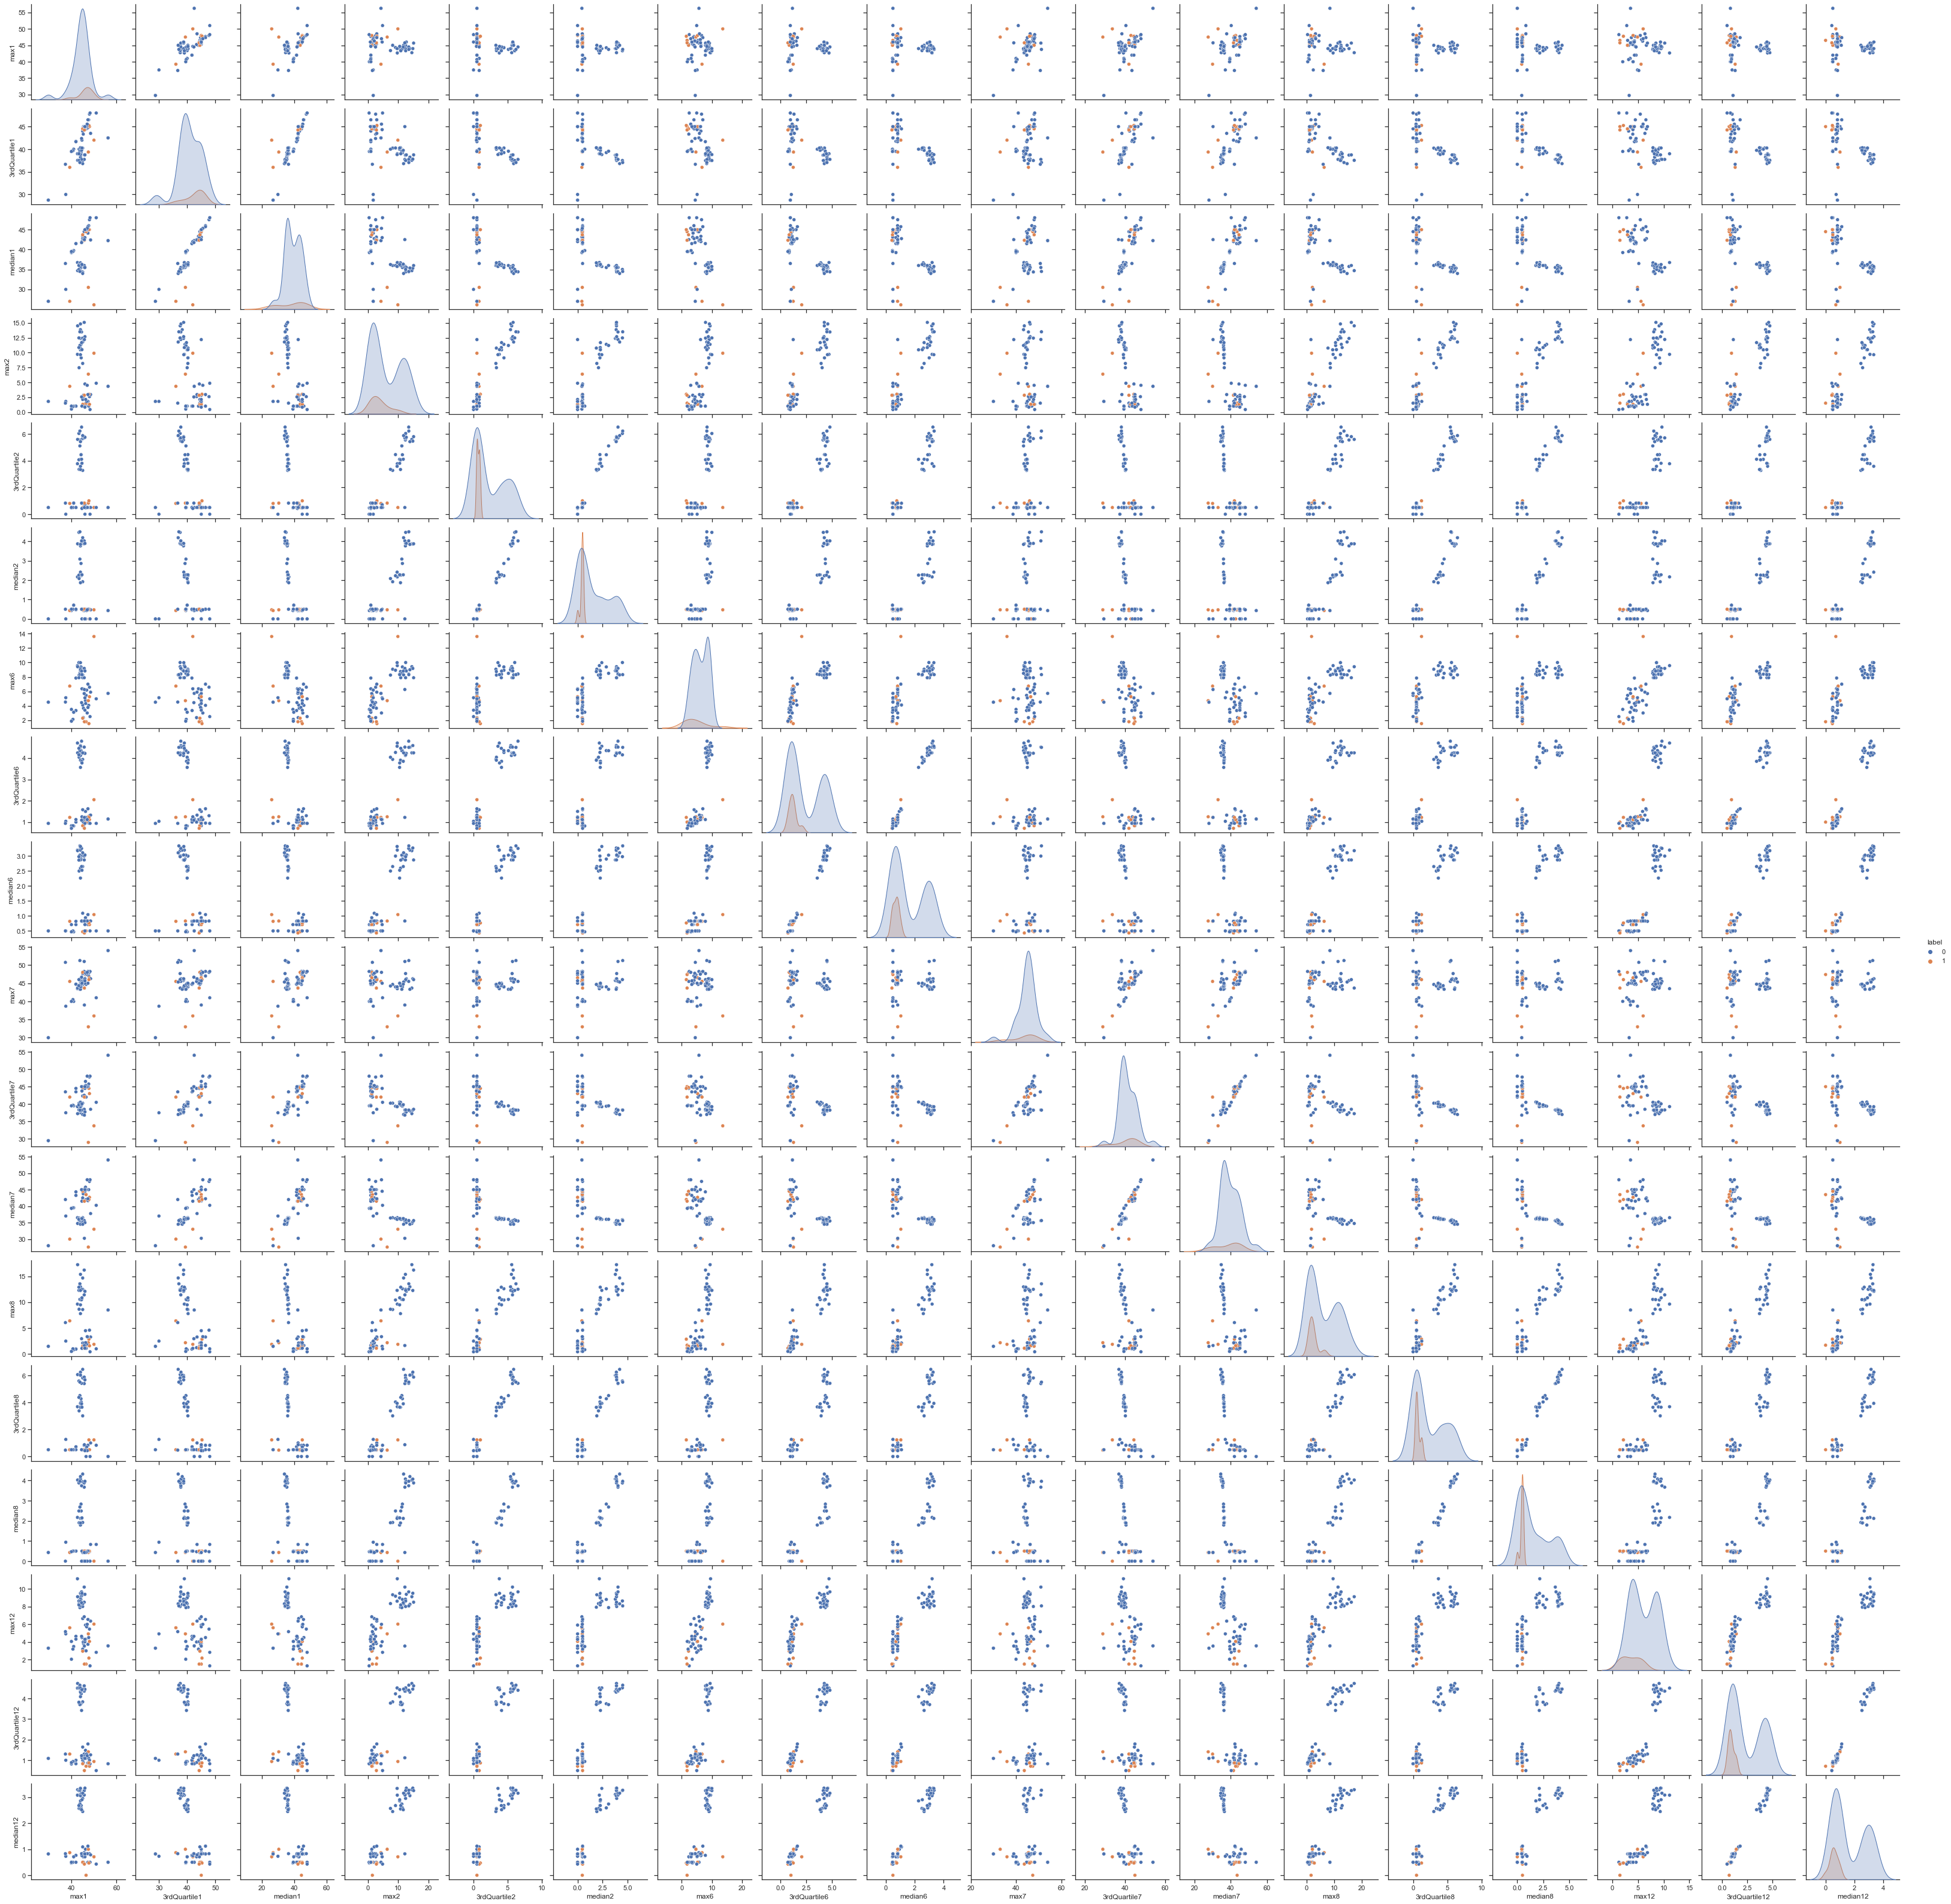

In [32]:
plot_df = df_2aii[['max1', '3rdQuartile1', 'median1', 'max2', '3rdQuartile2', 'median2', 'max6', '3rdQuartile6', 'median6', 'max7', '3rdQuartile7', 'median7', 'max8', '3rdQuartile8', 'median8', 'max12', '3rdQuartile12', 'median12', 'label']]

sns.set_theme(style="ticks")

sns.pairplot(plot_df, hue="label")

<hr>
<h4>2aiii.</h4>

- lp_results: A dictionary that will store 
    - Key: 'l' value
    - Values: (optimal number of features 'p', mean cross-validated scores, optimal feature names)

In [56]:
# Loop through every time series split from 1 to 20
# The below will contain a key-value pair of (l,p)->(model).
# The below will contain score for each (l,p) pair 
lp_results = {}

for l in np.arange(1,21):
    print(f'Split {l}: ')
    all_instances = {}

    for instance in train_collection.keys():
        # For every dataset in train collection dict, it makes l separate datasets.
        group = np.array_split(train_collection[instance], l)

        # Concatenate the splitted data to get 6*3*l features
        current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

        # Make features
        current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

        # Store to dict
        all_instances[instance] = current_df


    # Make a list of all csv file names for reference (instances)
    instances = [instance for instance in all_instances.keys()]


    # Dictionary to store all instances and their statistical properties
    train_stats = {}

    for i in instances:
        for idx, col in enumerate(all_instances[i]):
            train_stats['activity'] = instances
            train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
            train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
            train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

    df_2aiii = pd.DataFrame(train_stats)
    df_2aiii['label'] = df_2aiii['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)


    rfecv = RFECV(estimator=LogisticRegression(penalty="none"), cv=5, scoring='accuracy')
    rfecv = rfecv.fit(df_2aiii.iloc[:, 1:-1], df_2aiii.iloc[:, -1])

    lp_results[l] = [rfecv.n_features_, np.mean(rfecv.grid_scores_), rfecv.get_feature_names_out()]

    
    print(f'Done with splitting dataset into {l} parts and obtained scores')

lp_2aiii = pd.DataFrame({
    'l': lp_results.keys(),
    'p': [lp_results[i][0] for i in range(1, 21)],
    'score': [lp_results[i][1] for i in range(1, 21)],
    'features': [list(lp_results[i][2]) for i in range(1, 21)] 
})

best_lp = lp_2aiii.sort_values(by=['score'], ascending=False)

best_lp.to_csv('../model_results/lp_2aiii.csv')

best_lp

Split 1: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 1 parts and obtained scores
Split 2: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 2 parts and obtained scores
Split 3: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 3 parts and obtained scores
Split 4: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 4 parts and obtained scores
Split 5: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 5 parts and obtained scores
Split 6: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 6 parts and obtained scores
Split 7: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 7 parts and obtained scores
Split 8: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 8 parts and obtained scores
Split 9: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 9 parts and obtained scores
Split 10: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 10 parts and obtained scores
Split 11: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 11 parts and obtained scores
Split 12: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 12 parts and obtained scores
Split 13: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 13 parts and obtained scores
Split 14: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 14 parts and obtained scores
Split 15: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 15 parts and obtained scores
Split 16: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 16 parts and obtained scores
Split 17: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 17 parts and obtained scores
Split 18: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 18 parts and obtained scores
Split 19: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Done with splitting dataset into 19 parts and obtained scores
Split 20: 
Done with splitting dataset into 20 parts and obtained scores


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


,l,p,score,features
14,15,37,0.968901,"[max5, 3rdQuartile5, max11, 3rdQuartile11, med..."
6,7,10,0.966832,"[max5, 3rdQuartile5, max11, 3rdQuartile11, med..."
3,4,5,0.965614,"[max5, 3rdQuartile5, max12, 3rdQuartile13, med..."
16,17,44,0.965054,"[max5, 3rdQuartile5, max11, 3rdQuartile11, med..."
7,8,21,0.964187,"[max5, 3rdQuartile5, median5, max7, median9, m..."
5,6,2,0.963614,"[max5, max36]"
15,16,115,0.962679,"[max5, 3rdQuartile5, median5, median9, max11, ..."
4,5,18,0.962271,"[median3, max5, 3rdQuartile5, median5, max8, m..."
11,12,31,0.959091,"[max5, 3rdQuartile5, median5, max11, 3rdQuarti..."
8,9,41,0.958337,"[max5, 3rdQuartile5, median5, median9, max11, ..."


<h4>Observations</h4>

- Based on the table shown above for 2aiii results, the best (l,p) pair is (15,37) which corresponds to 15 splits and 37 features since it shows highest cross-validated accuracy.

- Cross Validation:
    - <b>Right Way</b>: Apply cross-validation to both feature selection process as well as classifier training. We want to make sure that there is less variability in our feature selection process (similar features are selected) due to sample variability in our dataset. Feature selection based on logistic regression estimator is also form of training and hence requires a validation set.
    - <b>Wrong Way</b>: Applying only cv when training the logistic regression classifier. This is an issue because every time the dataset goes through rfe step, a different set of features may get selected and then fed into the model. Since the model will recieve different set of predictors for training, it can lead to different error and accuracy estimates which is undesirable. 

<h4>Part iv.</h4>

Finished making dataset and now onto training model
model trained!


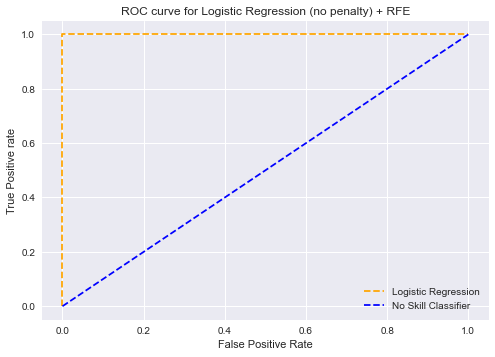

The AUC score: 1.0
Confusion Matrix:
[[60  0]
 [ 0  9]]
Train Accuracy: 1.0


In [59]:
l_iv = best_lp.iloc[0, 0]
features_iv = best_lp.iloc[0,3]

all_instances = {}

for instance in train_collection.keys():
    # For every dataset in train collection dict, it makes l separate datasets.
    group = np.array_split(train_collection[instance], l_iv)

    # Concatenate the splitted data to get 6*3*l features
    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    # Make features
    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    # Store to dict
    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
train_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        train_stats['activity'] = instances
        train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_2aiv = pd.DataFrame(train_stats)
df_2aiv['label'] = df_2aiv['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)
print("Finished making dataset and now onto training model")

model_2aiv = LogisticRegression(penalty='none')

X_train = df_2aiv.loc[:, features_iv]
y_train = df_2aiv.iloc[:, -1]
model_2aiv.fit(X_train, y_train)
print('model trained!')
y_pred_train = model_2aiv.predict(X_train)

# Confusion Matrix
conf = confusion_matrix(y_train, y_pred_train)

# ROC AUC score
roc_auc = roc_auc_score(y_train, y_pred_train)

# Plotting the ROC-AUC curve 'logistic regression'
fpr1, tpr1, thresh1 = roc_curve(y_train, y_pred_train, pos_label=1)

# Plotting the ROC AUC curve for 'no-skill classifier'
random_probs = [0 for i in range(len(y_train))]
p_fpr, p_tpr, _ = roc_curve(y_train, random_probs, pos_label=1)

plt.style.use('seaborn')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='No Skill Classifier')
# title
plt.title('ROC curve for Logistic Regression (no penalty) + RFE')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

print('The AUC score:', roc_auc)
print('Confusion Matrix:')
print(conf)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train)}')

In [64]:
pickle.dump(model_2aiv, open('../model_results/logreg_2iav.sav', 'wb'))

In [60]:
X_pvals = df_2aiv.loc[:, features_iv]
y_pvals = df_2aiv.iloc[:, -1]

lr = sm.Logit(y_pvals, sm.add_constant(X_pvals)).fit(method='bfgs')

print(lr.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       31
Method:                           MLE   Df Model:                           37
Date:                Fri, 04 Mar 2022   Pseudo R-squ.:                   1.000
Time:                        18:33:37   Log-Likelihood:            -1.1714e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                   0.03928
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0133   2.48e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
lr.pvalues

const            1.000000
max5             0.999885
3rdQuartile5     0.999999
max11            0.999992
3rdQuartile11    0.999996
median11         0.999982
median15         0.999955
max17            0.999985
3rdQuartile17    0.999992
median17         0.999950
max23            0.999987
3rdQuartile23    1.000000
median23         0.999974
3rdQuartile29    0.999996
median29         0.999998
max30            0.999981
3rdQuartile39    0.999871
max43            0.999959
3rdQuartile47    0.999950
max49            0.999981
3rdQuartile49    0.999958
median49         0.999970
median53         0.999984
max55            0.999950
3rdQuartile55    0.999986
max61            0.999983
3rdQuartile61    0.999973
median63         0.999859
max64            0.999919
3rdQuartile67    0.999967
3rdQuartile75    0.999993
max78            0.999999
max81            0.999932
3rdQuartile81    0.999968
max82            0.999957
3rdQuartile83    0.999995
median83         0.999988
max84            0.999952
dtype: float

<h4>Part v.</h4>

In [65]:
all_instances = {}

for instance in test_collection.keys():
    # For every dataset in train collection dict, it makes l separate datasets.
    group = np.array_split(test_collection[instance], l_iv)

    # Concatenate the splitted data to get 6*3*l features
    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    # Make features
    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    # Store to dict
    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
test_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        test_stats['activity'] = instances
        test_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        test_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        test_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_test_2aiv = pd.DataFrame(test_stats)
df_test_2aiv['label'] = df_test_2aiv['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)

X_test = df_test_2aiv.loc[:, features_iv]
y_test = df_test_2aiv.iloc[:, -1]

y_pred_test = model_2aiv.predict(X_test)

print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train)}')


Test Accuracy: 1.0
Train Accuracy: 1.0


<h4>Part vi.</h4>

- The classes do seem to be well separated since I got a 'perfect separation' error which means there was instability in calculating the logistic parameters. This errors happens mostly due to complete separation of the classes and therefore there are infinitely many parameters to be estimated. 

In [66]:
conf

array([[60,  0],
       [ 0,  9]])

- Yes, there is imbalanced class and that corresponds to the class 1 ('bending'). 

<h4>Part vii.</h4>
<u>Case Control Sampling:</u>

Before oversampling: Counter({0: 60, 1: 9})
After oversampling: Counter({0: 60, 1: 60})


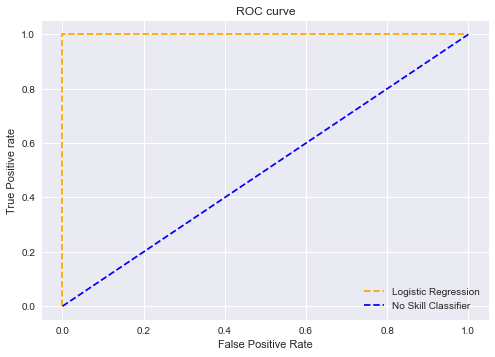

The AUC score: 1.0
Confusion Matrix:
[[60  0]
 [ 0 60]]


In [67]:
over = SMOTE(random_state=42)
model = LogisticRegression(penalty="none")

X = df_2aiv.loc[:, features_iv]
y = df_2aiv.iloc[:, -1]

print(f'Before oversampling: {Counter(y)}')

X_smote, y_smote = over.fit_resample(X, y)

print(f'After oversampling: {Counter(y_smote)}')

model.fit(X_smote, y_smote)

pred_y = model.predict(X_smote)
roc_auc = roc_auc_score(y_smote, pred_y)

conf = confusion_matrix(y_smote, pred_y)

fpr1, tpr1, thresh1 = roc_curve(y_smote, pred_y, pos_label=1)

random_probs = [0 for i in range(len(y_smote))]
p_fpr, p_tpr, _ = roc_curve(y_smote, random_probs, pos_label=1)

plt.style.use('seaborn')
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='No Skill Classifier')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

print('The AUC score:', roc_auc)
print('Confusion Matrix:')
print(conf)

<h2>2(b) Binary Classification using L1-penalized Logistic Regression</h2>

<h4>Part i.</h4>

In [68]:
lc_results = {}

for l in np.arange(1,21):
    print(f'Split {l}: ')
    all_instances = {}

    for instance in train_collection.keys():
        # For every dataset in train collection dict, it makes l separate datasets.
        group = np.array_split(train_collection[instance], l)

        # Concatenate the splitted data to get 6*3*l features
        current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

        # Make features
        current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

        # Store to dict
        all_instances[instance] = current_df


    # Make a list of all csv file names for reference (instances)
    instances = [instance for instance in all_instances.keys()]


    # Dictionary to store all instances and their statistical properties
    train_stats = {}

    for i in instances:
        for idx, col in enumerate(all_instances[i]):
            train_stats['activity'] = instances
            train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
            train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
            train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

    df = pd.DataFrame(train_stats)
    df['label'] = df['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)

    X = df.iloc[:, 1:-1]
    y = df.iloc[:, -1]

    scaler = StandardScaler().fit(X)
    X_train_std = scaler.transform(X)

    logreg = LogisticRegressionCV(penalty='l1', random_state=42, max_iter=1000, solver='liblinear')
    logreg.fit(X_train_std, y)
    lc_results[l] = [logreg.C_[0], logreg.scores_[1].mean(axis=0).max(), logreg, scaler]
    
    print(f'Done with splitting dataset into {l} parts and obtained the weight of L1 penalty')

lc_2bi = pd.DataFrame({
    'l': lc_results.keys(),
    'c': [lc_results[i][0] for i in range(1, 21)],
    'score': [lc_results[i][1] for i in range(1, 21)],
    'model': [lc_results[i][2] for i in range(1, 21)],
    'scaler': [lc_results[i][3] for i in range(1, 21)]
})

best_lc = lc_2bi.sort_values(by=['score'], ascending=False)

best_lc.to_csv('../model_results/lc_2bi.csv')

best_lc

Split 1: 
Done with splitting dataset into 1 parts and obtained the weight of L1 penalty
Split 2: 
Done with splitting dataset into 2 parts and obtained the weight of L1 penalty
Split 3: 
Done with splitting dataset into 3 parts and obtained the weight of L1 penalty
Split 4: 
Done with splitting dataset into 4 parts and obtained the weight of L1 penalty
Split 5: 
Done with splitting dataset into 5 parts and obtained the weight of L1 penalty
Split 6: 
Done with splitting dataset into 6 parts and obtained the weight of L1 penalty
Split 7: 
Done with splitting dataset into 7 parts and obtained the weight of L1 penalty
Split 8: 
Done with splitting dataset into 8 parts and obtained the weight of L1 penalty
Split 9: 
Done with splitting dataset into 9 parts and obtained the weight of L1 penalty
Split 10: 
Done with splitting dataset into 10 parts and obtained the weight of L1 penalty
Split 11: 
Done with splitting dataset into 11 parts and obtained the weight of L1 penalty
Split 12: 
Done w

,l,c,score,model,scaler
2,3,0.359381,0.971429,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
3,4,2.782559,0.971429,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
6,7,21.544347,0.971429,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
12,13,1291.549665,0.970330,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
4,5,10000.000000,0.970330,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
7,8,10000.000000,0.970330,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
15,16,1291.549665,0.970330,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
19,20,2.782559,0.957143,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
11,12,2.782559,0.957143,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
18,19,166.810054,0.956044,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()


- The best (l,c) is for l=3 and c=0.3594 since it has highest score.

In [69]:
l_2bi = best_lc.iloc[0, 0]
model_2bi = best_lc.iloc[0,3]
scaler_2bi = best_lc.iloc[0,4]
score_2bi = best_lc.iloc[0,2]

print(l_2bi)
print(model_2bi)
print(scaler_2bi)

3
LogisticRegressionCV(max_iter=1000, penalty='l1', random_state=42,
                     solver='liblinear')
StandardScaler()


In [71]:
all_instances = {}


for instance in test_collection.keys():
    # For every dataset in train collection dict, it makes l separate datasets.
    group = np.array_split(test_collection[instance], l_2bi)

    # Concatenate the splitted data to get 6*3*l features
    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    # Make features
    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    # Store to dict
    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
test_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        test_stats['activity'] = instances
        test_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        test_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        test_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_test_2bi = pd.DataFrame(test_stats)
df_test_2bi['label'] = df_test_2bi['activity'].apply(lambda x: 1 if label_find_binary(x) == "bending" else 0)

X_test = df_test_2bi.iloc[:, 1:-1]
y_test = df_test_2bi.iloc[:, -1]

X_test_std = scaler_2bi.transform(X_test)

y_pred_test = model_2bi.predict(X_test_std)

print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test)}')
print(f'Train Accuracy: {score_2bi}')

Test Accuracy: 0.8947368421052632
Train Accuracy: 0.9714285714285715


<h4>Part ii.</h4>
<li><b>Performance</b>: Logistic Regression with RFECV performs better than the one with L1 penalty since it has highest test accuracy score. (without L1 -> 100% | with L1 -> 89.5%).</li>
<li><b>Implementation</b>: L1 penalty regression is easier because we didn't have retrain the logistic regression with the selected subset of features as we did with RFE+Logistic Regression. Training time was far less for L1 penalty compared to the RFE+Logistic.</li>

<h2>2(c) Multi-Class Classification</h2>

In [72]:
# Function to find activities corresponding to bending to give a label.
def label_find(x):
    x_ = re.search('[a-z]*', x).group()
    
    dict_ = {
        'bending': 0,
        'cycling': 1,
        'lying': 2, 
        'sitting': 3, 
        'standing': 4, 
        'walking': 5 
    }

    if x_ in dict_:
        return dict_[x_]

In [73]:
df_2ai['activity'].apply(lambda x: label_find(x)).value_counts()

3    12
1    12
4    12
2    12
5    12
0     9
Name: activity, dtype: int64

In [74]:
lmn_results = {}

for l in np.arange(1,21):
    print(f'Split {l}: ')
    all_instances = {}

    for instance in train_collection.keys():
        # For every dataset in train collection dict, it makes l separate datasets.
        group = np.array_split(train_collection[instance], l)

        # Concatenate the splitted data to get 6*3*l features
        current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

        # Make features
        current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

        # Store to dict
        all_instances[instance] = current_df


    # Make a list of all csv file names for reference (instances)
    instances = [instance for instance in all_instances.keys()]


    # Dictionary to store all instances and their statistical properties
    train_stats = {}

    for i in instances:
        for idx, col in enumerate(all_instances[i]):
            train_stats['activity'] = instances
            train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
            train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
            train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

    df_2ci = pd.DataFrame(train_stats)
    df_2ci['label'] = df_2ci['activity'].apply(lambda x: label_find(x))

    X = df_2ci.iloc[:, 1:-1]
    y = df_2ci.iloc[:, -1]

    scaler = StandardScaler().fit(X)
    X_train_std = scaler.transform(X)

    logreg = LogisticRegressionCV(penalty='l1', random_state=42, max_iter=1000, solver='saga')
    logreg.fit(X_train_std, y)
    lmn_results[l] = [logreg.C_[0], logreg.scores_[1].mean(axis=0).max(), logreg, scaler]
    
    print(f'Done with splitting dataset into {l} parts and obtained the weight of L1 penalty')

lmn_2ci = pd.DataFrame({
    'l': lmn_results.keys(),
    'c': [lmn_results[i][0] for i in range(1, 21)],
    'score': [lmn_results[i][1] for i in range(1, 21)],
    'model': [lmn_results[i][2] for i in range(1, 21)],
    'scaler': [lmn_results[i][3] for i in range(1, 21)]
})

best_lmn = lmn_2ci.sort_values(by=['score'], ascending=False)

best_lmn.to_csv('../model_results/lmn_2ci.csv')

best_lmn

Split 1: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 1 parts and obtained the weight of L1 penalty
Split 2: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 2 parts and obtained the weight of L1 penalty
Split 3: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 3 parts and obtained the weight of L1 penalty
Split 4: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 4 parts and obtained the weight of L1 penalty
Split 5: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 5 parts and obtained the weight of L1 penalty
Split 6: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 6 parts and obtained the weight of L1 penalty
Split 7: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 7 parts and obtained the weight of L1 penalty
Split 8: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 8 parts and obtained the weight of L1 penalty
Split 9: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 9 parts and obtained the weight of L1 penalty
Split 10: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 10 parts and obtained the weight of L1 penalty
Split 11: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 11 parts and obtained the weight of L1 penalty
Split 12: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 12 parts and obtained the weight of L1 penalty
Split 13: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 13 parts and obtained the weight of L1 penalty
Split 14: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 14 parts and obtained the weight of L1 penalty
Split 15: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 15 parts and obtained the weight of L1 penalty
Split 16: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 16 parts and obtained the weight of L1 penalty
Split 17: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 17 parts and obtained the weight of L1 penalty
Split 18: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 18 parts and obtained the weight of L1 penalty
Split 19: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 19 parts and obtained the weight of L1 penalty
Split 20: 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Done with splitting dataset into 20 parts and obtained the weight of L1 penalty


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,l,c,score,model,scaler
8,9,21.544347,0.842857,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
0,1,166.810054,0.840659,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
18,19,0.359381,0.828571,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
1,2,1291.549665,0.814286,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
2,3,2.782559,0.813187,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
11,12,0.359381,0.813187,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
17,18,0.359381,0.800000,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
10,11,2.782559,0.800000,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
5,6,2.782559,0.800000,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()
19,20,0.359381,0.798901,"LogisticRegressionCV(max_iter=1000, penalty='l...",StandardScaler()


In [75]:
l_2ci = best_lmn.iloc[0, 0]
model_2ci = best_lmn.iloc[0,3]
scaler_2ci = best_lmn.iloc[0,4]
score_2ci = best_lmn.iloc[0,2]

print(l_2ci)
print(model_2ci)
print(scaler_2ci)

9
LogisticRegressionCV(max_iter=1000, penalty='l1', random_state=42,
                     solver='saga')
StandardScaler()


In [76]:
all_instances = {}


for instance in test_collection.keys():
    # For every dataset in train collection dict, it makes l separate datasets.
    group = np.array_split(test_collection[instance], l_2ci)

    # Concatenate the splitted data to get 6*3*l features
    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    # Make features
    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    # Store to dict
    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
test_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        test_stats['activity'] = instances
        test_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        test_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        test_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_test_2ci = pd.DataFrame(test_stats)
df_test_2ci['label'] = df_test_2ci['activity'].apply(lambda x: label_find(x))

X_test = df_test_2ci.iloc[:, 1:-1]
y_test = df_test_2ci.iloc[:, -1]

X_test_std = scaler_2ci.transform(X_test)

y_pred_test = model_2ci.predict(X_test_std)

error = 1 - accuracy_score(y_test, y_pred_test)

print(f'Test Error: {error}')

Test Error: 0.1578947368421053


<p><u>Making ROC curve and Confusion Matrix for Multi-Class Classification</u></p>

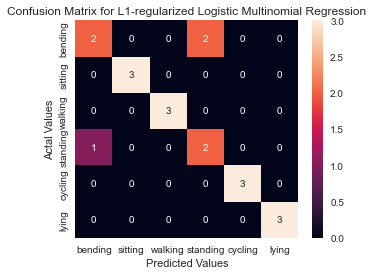

In [77]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_test)

cm_df = pd.DataFrame(cm, index=['bending', 'sitting', 'walking', 'standing', 'cycling', 'lying'], columns=['bending', 'sitting', 'walking', 'standing', 'cycling', 'lying'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for L1-regularized Logistic Multinomial Regression')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<h4>Part ii.</h4>

<u>Gaussian NB</u>

In [116]:
gnb_results = {}

for l in np.arange(1,21):
    print(f'Split {l}: ')
    all_instances = {}

    for instance in train_collection.keys():
        # For every dataset in train collection dict, it makes l separate datasets.
        group = np.array_split(train_collection[instance], l)

        # Concatenate the splitted data to get 6*3*l features
        current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

        # Make features
        current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

        # Store to dict
        all_instances[instance] = current_df


    # Make a list of all csv file names for reference (instances)
    instances = [instance for instance in all_instances.keys()]


    # Dictionary to store all instances and their statistical properties
    train_stats = {}

    for i in instances:
        for idx, col in enumerate(all_instances[i]):
            train_stats['activity'] = instances
            train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
            train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
            train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

    df_2cii = pd.DataFrame(train_stats)
    df_2cii['label'] = df_2cii['activity'].apply(lambda x: label_find(x))

    X = df_2cii.iloc[:, 1:-1]
    y = df_2cii.iloc[:, -1]

    scaler = StandardScaler().fit(X)
    X_train_std = scaler.transform(X)

    gnb = GaussianNB()
    gnb.fit(X_train_std, y)
    gnb_results[l] = [gnb.score(X_train_std, y), gnb, scaler]
    
    print(f'Done with splitting dataset into {l} parts')

gnb_2cii = pd.DataFrame({
    'l': gnb_results.keys(),
    'score': [gnb_results[i][0] for i in range(1, 21)],
    'gnb': [gnb_results[i][1] for i in range(1, 21)],
    'scaler': [gnb_results[i][2] for i in range(1, 21)]
})

best_gnb = gnb_2cii.sort_values(by=['score'], ascending=False)

best_gnb.to_csv('../model_results/lgnb_2cii.csv')

best_gnb

Split 1: 
Done with splitting dataset into 1 parts
Split 2: 
Done with splitting dataset into 2 parts
Split 3: 
Done with splitting dataset into 3 parts
Split 4: 
Done with splitting dataset into 4 parts
Split 5: 
Done with splitting dataset into 5 parts
Split 6: 
Done with splitting dataset into 6 parts
Split 7: 
Done with splitting dataset into 7 parts
Split 8: 
Done with splitting dataset into 8 parts
Split 9: 
Done with splitting dataset into 9 parts
Split 10: 
Done with splitting dataset into 10 parts
Split 11: 
Done with splitting dataset into 11 parts
Split 12: 
Done with splitting dataset into 12 parts
Split 13: 
Done with splitting dataset into 13 parts
Split 14: 
Done with splitting dataset into 14 parts
Split 15: 
Done with splitting dataset into 15 parts
Split 16: 
Done with splitting dataset into 16 parts
Split 17: 
Done with splitting dataset into 17 parts
Split 18: 
Done with splitting dataset into 18 parts
Split 19: 
Done with splitting dataset into 19 parts
Split 20: 


,l,score,gnb,scaler
10,11,0.985507,GaussianNB(),StandardScaler()
1,2,0.985507,GaussianNB(),StandardScaler()
18,19,0.985507,GaussianNB(),StandardScaler()
17,18,0.985507,GaussianNB(),StandardScaler()
16,17,0.985507,GaussianNB(),StandardScaler()
15,16,0.985507,GaussianNB(),StandardScaler()
14,15,0.985507,GaussianNB(),StandardScaler()
13,14,0.985507,GaussianNB(),StandardScaler()
12,13,0.985507,GaussianNB(),StandardScaler()
11,12,0.985507,GaussianNB(),StandardScaler()


In [139]:
l_2cii_gnb = best_gnb.iloc[1, 0]
score_2cii_gnb = best_gnb.iloc[1,1]
model_2cii_gnb = best_gnb.iloc[1,2]
scaler_2cii_gnb = best_gnb.iloc[1,3]

print(l_2cii_gnb)
print(score_2cii_gnb)
print(scaler_2cii_gnb)

2
0.9855072463768116
StandardScaler()


In [140]:
all_instances = {}


for instance in test_collection.keys():
    # For every dataset in train collection dict, it makes l separate datasets.
    group = np.array_split(test_collection[instance], l_2cii_gnb)

    # Concatenate the splitted data to get 6*3*l features
    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    # Make features
    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    # Store to dict
    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
test_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        test_stats['activity'] = instances
        test_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        test_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        test_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_test_2cii = pd.DataFrame(test_stats)
df_test_2cii['label'] = df_test_2cii['activity'].apply(lambda x: label_find(x))

X_test = df_test_2cii.iloc[:, 1:-1]
y_test = df_test_2cii.iloc[:, -1]

X_test_std = scaler_2cii_gnb.transform(X_test)

y_pred_test = model_2cii_gnb.predict(X_test_std)

error = 1 - accuracy_score(y_test, y_pred_test)

print(f'Test Error: {error}')

Test Error: 0.052631578947368474


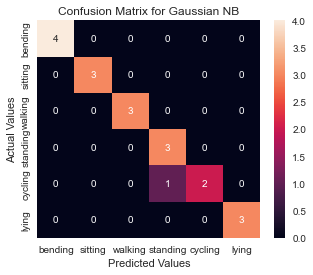

In [141]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_test)

cm_df = pd.DataFrame(cm, index=['bending', 'sitting', 'walking', 'standing', 'cycling', 'lying'], columns=['bending', 'sitting', 'walking', 'standing', 'cycling', 'lying'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for Gaussian NB')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<u>Multinomial NB</u>

In [123]:
mnb_results = {}

for l in np.arange(1,21):
    print(f'Split {l}: ')
    all_instances = {}

    for instance in train_collection.keys():
        # For every dataset in train collection dict, it makes l separate datasets.
        group = np.array_split(train_collection[instance], l)

        # Concatenate the splitted data to get 6*3*l features
        current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

        # Make features
        current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

        # Store to dict
        all_instances[instance] = current_df


    # Make a list of all csv file names for reference (instances)
    instances = [instance for instance in all_instances.keys()]


    # Dictionary to store all instances and their statistical properties
    train_stats = {}

    for i in instances:
        for idx, col in enumerate(all_instances[i]):
            train_stats['activity'] = instances
            train_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
            train_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
            train_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

    df_2cii = pd.DataFrame(train_stats)
    df_2cii['label'] = df_2cii['activity'].apply(lambda x: label_find(x))

    X = df_2cii.iloc[:, 1:-1]
    y = df_2cii.iloc[:, -1]

    mnb = MultinomialNB()
    mnb.fit(X, y)
    mnb_results[l] = [mnb.score(X, y), mnb]
    
    print(f'Done with splitting dataset into {l} parts')

mnb_2cii = pd.DataFrame({
    'l': mnb_results.keys(),
    'score': [mnb_results[i][0] for i in range(1, 21)],
    'mnb': [mnb_results[i][1] for i in range(1, 21)],
})

best_mnb = mnb_2cii.sort_values(by=['score'], ascending=False)

best_mnb.to_csv('../model_results/mnb_2cii.csv')

best_mnb

Split 1: 
Done with splitting dataset into 1 parts
Split 2: 
Done with splitting dataset into 2 parts
Split 3: 
Done with splitting dataset into 3 parts
Split 4: 
Done with splitting dataset into 4 parts
Split 5: 
Done with splitting dataset into 5 parts
Split 6: 
Done with splitting dataset into 6 parts
Split 7: 
Done with splitting dataset into 7 parts
Split 8: 
Done with splitting dataset into 8 parts
Split 9: 
Done with splitting dataset into 9 parts
Split 10: 
Done with splitting dataset into 10 parts
Split 11: 
Done with splitting dataset into 11 parts
Split 12: 
Done with splitting dataset into 12 parts
Split 13: 
Done with splitting dataset into 13 parts
Split 14: 
Done with splitting dataset into 14 parts
Split 15: 
Done with splitting dataset into 15 parts
Split 16: 
Done with splitting dataset into 16 parts
Split 17: 
Done with splitting dataset into 17 parts
Split 18: 
Done with splitting dataset into 18 parts
Split 19: 
Done with splitting dataset into 19 parts
Split 20: 


,l,score,mnb
10,11,0.971014,MultinomialNB()
16,17,0.971014,MultinomialNB()
2,3,0.971014,MultinomialNB()
3,4,0.971014,MultinomialNB()
4,5,0.971014,MultinomialNB()
5,6,0.971014,MultinomialNB()
6,7,0.971014,MultinomialNB()
7,8,0.971014,MultinomialNB()
8,9,0.971014,MultinomialNB()
9,10,0.971014,MultinomialNB()


In [126]:
l_2cii_mnb = best_mnb.iloc[2, 0]
score_2cii_mnb = best_mnb.iloc[2,1]
model_2cii_mnb = best_mnb.iloc[2,2]

print(l_2cii_mnb)
print(score_2cii_mnb)

3
0.9710144927536232


In [127]:
all_instances = {}


for instance in test_collection.keys():
    # For every dataset in train collection dict, it makes l separate datasets.
    group = np.array_split(test_collection[instance], l_2cii_mnb)

    # Concatenate the splitted data to get 6*3*l features
    current_df = pd.concat([x.reset_index(drop=True) for x in group], axis=1, ignore_index=True)

    # Make features
    current_df.columns = [f'i_{index+1}' for index in range(len(current_df.columns))]

    # Store to dict
    all_instances[instance] = current_df


# Make a list of all csv file names for reference (instances)
instances = [instance for instance in all_instances.keys()]


# Dictionary to store all instances and their statistical properties
test_stats = {}

for i in instances:
    for idx, col in enumerate(all_instances[i]):
        test_stats['activity'] = instances
        test_stats[f'max{idx+1}'] = [all_instances[instance][col].max() for instance in all_instances.keys()]
        test_stats[f'3rdQuartile{idx+1}'] = [all_instances[instance][col].quantile(q=0.75) for instance in all_instances.keys()]
        test_stats[f'median{idx+1}'] = [all_instances[instance][col].median() for instance in all_instances.keys()]

df_test_2cii = pd.DataFrame(test_stats)
df_test_2cii['label'] = df_test_2cii['activity'].apply(lambda x: label_find(x))

X_test = df_test_2cii.iloc[:, 1:-1]
y_test = df_test_2cii.iloc[:, -1]

y_pred_test = model_2cii_mnb.predict(X_test)

error = 1 - accuracy_score(y_test, y_pred_test)

print(f'Test Error: {error}')

Test Error: 0.052631578947368474


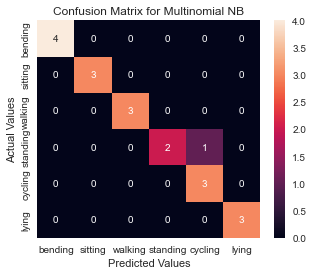

In [130]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred_test)

cm_df = pd.DataFrame(cm, index=['bending', 'sitting', 'walking', 'standing', 'cycling', 'lying'], columns=['bending', 'sitting', 'walking', 'standing', 'cycling', 'lying'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for Multinomial NB')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<h4>Which method is better for multi-class classification?</h4>
<li>Naive Bayes classifier is superior in performance since it only resulted in 0.05 test error rate. Logistic Regression showed 0.15 test error rate. This proves that Naive Bayes does a better job in generalizing well to unseen test instances.</li>

<h2>References</h2>
<li><a>https://www.analyticsvidhya.com/blog/2021/11/implementation-of-gaussian-naive-bayes-in-python-sklearn/</a></li>
<li><a>https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html</a></li>
<li><a>https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/</a></li>
<li><a>https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html</a></li>
<li><a>https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression</a></li>
<li><a>https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/</a></li>
